In [1]:
import os
import sys
import time
import pickle
import logging
import argparse
import numpy as np
from typing import List


import random
import torch
import torch.nn as nn
import torch.nn.functional as F


sys.path.append("..")
from data import Data
import CNN
import MLP
import baselines


device = "cuda"

class Args: 
    """ Env Params ------------------------------ """

    num_agents: int = 0
    """ Number of agents: To be filled later  """

    prob: float = 0.0
    """ Probability of truncation: To be filled later  """

    corr: float = 0.00
    """ Correlation Probability: To be filled later """

    lambd: float = 0.00
    """ Tradeoff param: To be filled later """

    """ Neural Network Params -------------------- """

    CNN_net_arch: List[int] = [64, 64, 64, 64, 64]
    MLP_net_arch: List[int] = [256, 256, 256, 256, 256]
    """ Neural Network Architecture """

    act_fn = nn.LeakyReLU
    
    batch_size: int = 1024
    """ Batch Size """

    num_tst_samples: int = 20480
    """ Number of Test batches """
        
    num_tst_batches = num_tst_samples//batch_size

    seed: int = 24
    """ Random Seed """
        

def torch_var(x): 
    return torch.Tensor(x).to(device)

def plogp(x): 
    return - x * np.log2(np.maximum(x, 1e-8))

def compute_welfare(R, P, Q):
    return ((P * R).sum(-1).mean() + (Q * R).sum(-2).mean())/2.0
    
def compute_sim(R1, R2):
    num_agents = R1.shape[1]
    sim = 2*(R2 * R1).sum(-1).sum(-1) + ((1 - R2.sum(-1)) * (1 - R1.sum(-1))).sum(-1) + ((1 - R2.sum(-2)) * (1 - R1.sum(-2))).sum(-1)
    return sim.mean()/(2 * num_agents)
    
def compute_entropy(R):
    num_agents = R.shape[1]
    H = plogp(R).sum(-1).sum(-1) + 0.5 * plogp(1 - R.sum(-1)).sum(-1) + 0.5 * plogp(1 - R.sum(-2)).sum(-1)
    return H.mean()/num_agents/-np.log2(1/(num_agents + 1))
                

args = Args()
args.num_agents = 4
args.prob = 0.2


""" Seed for reproducibility """
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = True

In [2]:
model = CNN.Net(args.CNN_net_arch, args.act_fn).to(device)

lambdas = np.linspace(0, 1, 11)
WF_CNN = np.zeros((4, len(lambdas)))
EN_CNN = np.zeros((4, len(lambdas)))  
SIM_CNN = np.zeros((4, len(lambdas)))
                   

corr_all = [0.00, 0.25, 0.50, 0.75]

for i, corr in enumerate(corr_all):
    root_dir = os.path.join("..","experiments", "agents_%d"%(args.num_agents),  "corr_%.2f"%(corr), "CNN") 
    G = Data(args.num_agents, args.prob, corr) 
    for j, lam in enumerate(lambdas):
        model_path = os.path.join(root_dir, "CHECKPOINT_lambd_%.4f"%(lam))
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model'])
        
        random.seed(args.seed)
        np.random.seed(args.seed)
        
        wf = 0.0
        simp = 0.0
        simq = 0.0
        en = 0.0
        
        for _ in range(args.num_tst_batches): 
            P, Q = G.generate_batch(args.batch_size)
            p, q = torch_var(P), torch_var(Q)
            R = model(p, q).detach().cpu().numpy()
            wf += compute_welfare(R, P, Q)
            Rp = baselines.compute_DA_batch(P, Q)
            Rq = baselines.compute_DA_batch_switch(P, Q)
            simp += compute_sim(R, Rp)
            simq += compute_sim(R, Rq)
            en += compute_entropy(R)
            
            
        WF_CNN[i,j] = wf/args.num_tst_batches
        SIM_CNN[i,j]  = max(simp, simq)/args.num_tst_batches
        EN_CNN[i,j] = en/args.num_tst_batches

In [3]:
model = MLP.Net(args.MLP_net_arch, args.act_fn, args.num_agents).to(device)

lambdas = np.linspace(0, 1, 11)
WF_MLP = np.zeros((4, len(lambdas)))
EN_MLP = np.zeros((4, len(lambdas)))  
SIM_MLP = np.zeros((4, len(lambdas)))
                   

corr_all = [0.00, 0.25, 0.50, 0.75]

for i, corr in enumerate(corr_all):
    root_dir = os.path.join("..","experiments", "agents_%d"%(args.num_agents),  "corr_%.2f"%(corr), "MLP") 
    G = Data(args.num_agents, args.prob, corr) 
    for j, lam in enumerate(lambdas):
        model_path = os.path.join(root_dir, "CHECKPOINT_lambd_%.4f"%(lam))
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model'])
        
        random.seed(args.seed)
        np.random.seed(args.seed)
        
        wf = 0.0
        simp = 0.0
        simq = 0.0
        en = 0.0
        
        for _ in range(args.num_tst_batches): 
            P, Q = G.generate_batch(args.batch_size)
            p, q = torch_var(P), torch_var(Q)
            R = model(p, q).detach().cpu().numpy()
            wf += compute_welfare(R, P, Q)
            Rp = baselines.compute_DA_batch(P, Q)
            Rq = baselines.compute_DA_batch_switch(P, Q)
            simp += compute_sim(R, Rp)
            simq += compute_sim(R, Rq)
            en += compute_entropy(R)
            
            
        WF_MLP[i,j] = wf/args.num_tst_batches
        SIM_MLP[i,j]  = max(simp, simq)/args.num_tst_batches
        EN_MLP[i,j] = en/args.num_tst_batches  

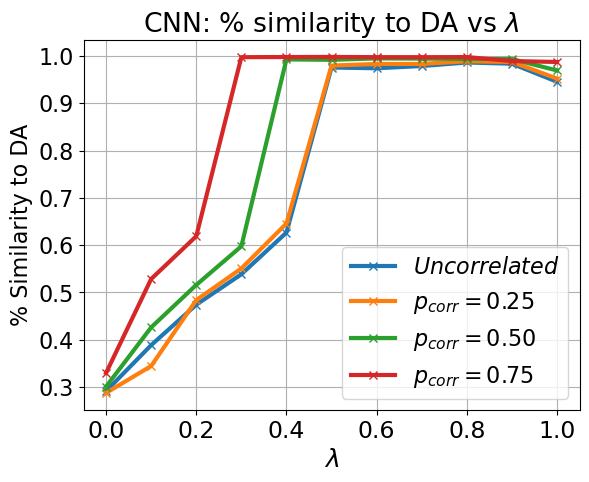

In [4]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
plt.plot(lambdas, SIM_CNN[0], lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.plot(lambdas, SIM_CNN[1], lw = 3.0, marker='x', label = r"$p_{corr} = 0.25$")
plt.plot(lambdas, SIM_CNN[2], lw = 3.0, marker='x', label = r"$p_{corr} = 0.50$")
plt.plot(lambdas, SIM_CNN[3], lw = 3.0, marker='x', label = r"$p_{corr} = 0.75$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("% Similarity to DA")
plt.title("CNN: % similarity to DA vs $\lambda$")
_ = plt.legend()

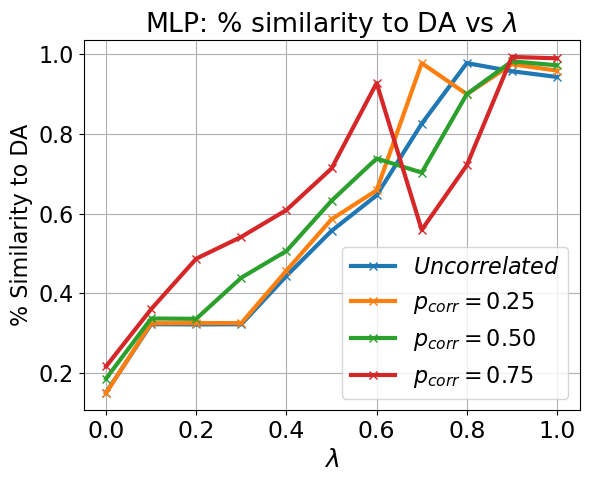

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
plt.plot(lambdas, SIM_MLP[0], lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.plot(lambdas, SIM_MLP[1], lw = 3.0, marker='x', label = r"$p_{corr} = 0.25$")
plt.plot(lambdas, SIM_MLP[2], lw = 3.0, marker='x', label = r"$p_{corr} = 0.50$")
plt.plot(lambdas, SIM_MLP[3], lw = 3.0, marker='x', label = r"$p_{corr} = 0.75$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("% Similarity to DA")
plt.title("MLP: % similarity to DA vs $\lambda$")
_ = plt.legend()

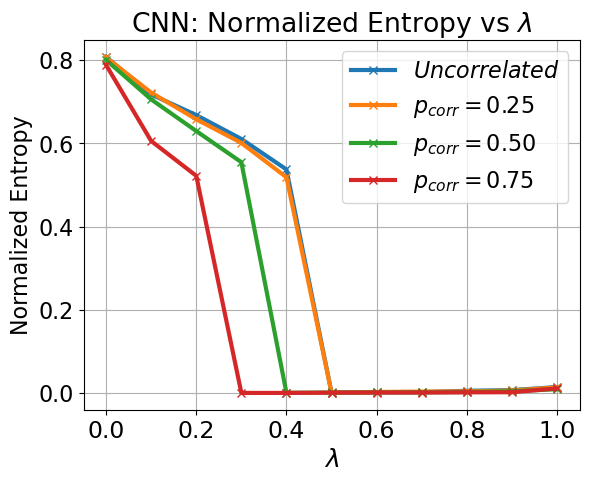

In [6]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
plt.plot(lambdas, EN_CNN[0], lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.plot(lambdas, EN_CNN[1], lw = 3.0, marker='x', label = r"$p_{corr} = 0.25$")
plt.plot(lambdas, EN_CNN[2], lw = 3.0, marker='x', label = r"$p_{corr} = 0.50$")
plt.plot(lambdas, EN_CNN[3], lw = 3.0, marker='x', label = r"$p_{corr} = 0.75$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("Normalized Entropy")
plt.title("CNN: Normalized Entropy vs $\lambda$")
_ = plt.legend()

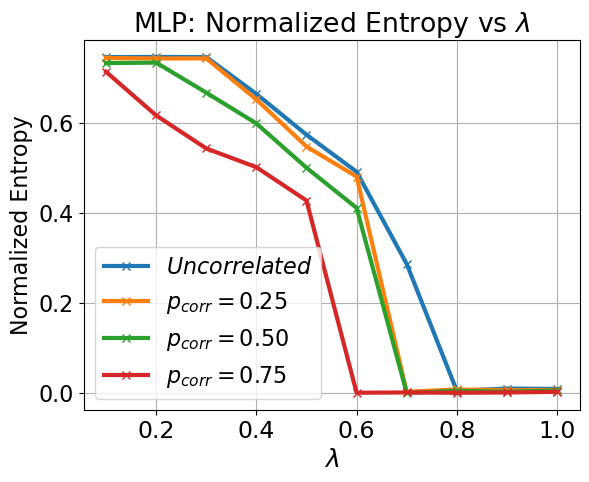

In [7]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
plt.plot(lambdas[1:], EN_MLP[0,1:], lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.plot(lambdas[1:], EN_MLP[1,1:], lw = 3.0, marker='x', label = r"$p_{corr} = 0.25$")
plt.plot(lambdas[1:], EN_MLP[2,1:], lw = 3.0, marker='x', label = r"$p_{corr} = 0.50$")
plt.plot(lambdas[1:], EN_MLP[3,1:], lw = 3.0, marker='x', label = r"$p_{corr} = 0.75$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("Normalized Entropy")
plt.title("MLP: Normalized Entropy vs $\lambda$")
_ = plt.legend()

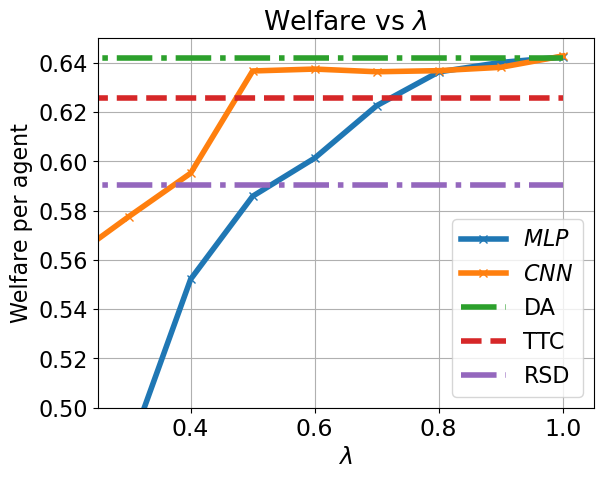

In [8]:
CORR = 0.00
root_dir = os.path.join("..","experiments", "agents_4",  "corr_%.2f"%(CORR))
with open(os.path.join(root_dir, "baselines", "data.p"), 'rb') as f:
    data = pickle.load(f)
    
    
DA_WF = data['DA_WF']
TTC_WF = data['TTC_WF']
RSD_WF = data['RSD_WF']

plt.plot(lambdas, WF_MLP[0], lw = 4.0, marker='x', label = r"$MLP$")
plt.plot(lambdas, WF_CNN[0], lw = 4.0, marker='x', label = r"$CNN$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 17)
plt.xticks(fontsize = 17)
plt.ylabel("Welfare per agent")
plt.plot([0, 1], [DA_WF, DA_WF], lw = 4.0,  ls = "dashdot", label = "DA")
plt.plot([0, 1], [TTC_WF, TTC_WF], lw = 4.0, ls = "dashed", label = "TTC")
plt.plot([0, 1], [RSD_WF, RSD_WF], lw = 4.0, ls = "dashdot", label = "RSD")

plt.legend()
plt.xlim([0.25, 1.05])
plt.ylim([0.5, 0.65])
_ = plt.title("Welfare vs $\lambda$")

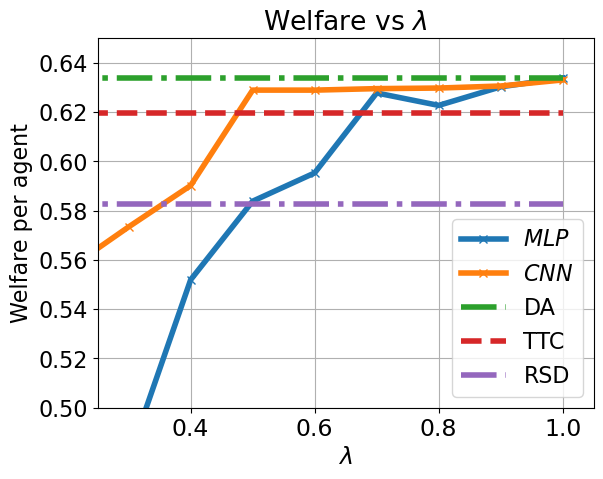

In [9]:
CORR = 0.25
root_dir = os.path.join("..","experiments", "agents_4",  "corr_%.2f"%(CORR))
with open(os.path.join(root_dir, "baselines", "data.p"), 'rb') as f:
    data = pickle.load(f)
    
    
DA_WF = data['DA_WF']
TTC_WF = data['TTC_WF']
RSD_WF = data['RSD_WF']

plt.plot(lambdas, WF_MLP[1], lw = 4.0, marker='x', label = r"$MLP$")
plt.plot(lambdas, WF_CNN[1], lw = 4.0, marker='x', label = r"$CNN$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 17)
plt.xticks(fontsize = 17)
plt.ylabel("Welfare per agent")
plt.plot([0, 1], [DA_WF, DA_WF], lw = 4.0,  ls = "dashdot", label = "DA")
plt.plot([0, 1], [TTC_WF, TTC_WF], lw = 4.0, ls = "dashed", label = "TTC")
plt.plot([0, 1], [RSD_WF, RSD_WF], lw = 4.0, ls = "dashdot", label = "RSD")

plt.legend()
plt.xlim([0.25, 1.05])
plt.ylim([0.5, 0.65])
_ = plt.title("Welfare vs $\lambda$")

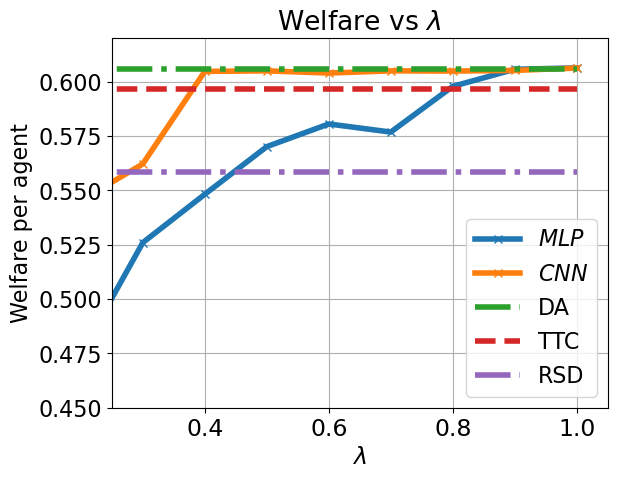

In [10]:
CORR = 0.5
root_dir = os.path.join("..","experiments", "agents_4",  "corr_%.2f"%(CORR))
with open(os.path.join(root_dir, "baselines", "data.p"), 'rb') as f:
    data = pickle.load(f)
    
    
DA_WF = data['DA_WF']
TTC_WF = data['TTC_WF']
RSD_WF = data['RSD_WF']

plt.plot(lambdas, WF_MLP[2], lw = 4.0, marker='x', label = r"$MLP$")
plt.plot(lambdas, WF_CNN[2], lw = 4.0, marker='x', label = r"$CNN$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 17)
plt.xticks(fontsize = 17)
plt.ylabel("Welfare per agent")
plt.plot([0, 1], [DA_WF, DA_WF], lw = 4.0,  ls = "dashdot", label = "DA")
plt.plot([0, 1], [TTC_WF, TTC_WF], lw = 4.0, ls = "dashed", label = "TTC")
plt.plot([0, 1], [RSD_WF, RSD_WF], lw = 4.0, ls = "dashdot", label = "RSD")

plt.legend()
plt.xlim([0.25, 1.05])
plt.ylim([0.45, 0.62])
_ = plt.title("Welfare vs $\lambda$")

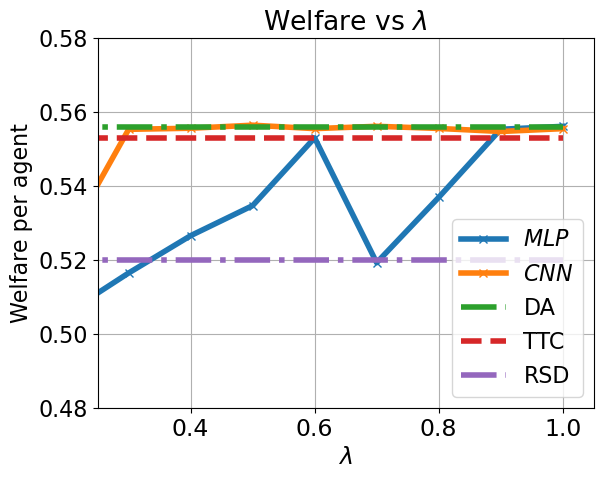

In [11]:
CORR = 0.75
root_dir = os.path.join("..","experiments", "agents_4",  "corr_%.2f"%(CORR))
with open(os.path.join(root_dir, "baselines", "data.p"), 'rb') as f:
    data = pickle.load(f)
    
    
DA_WF = data['DA_WF']
TTC_WF = data['TTC_WF']
RSD_WF = data['RSD_WF']

plt.plot(lambdas, WF_MLP[3], lw = 4.0, marker='x', label = r"$MLP$")
plt.plot(lambdas, WF_CNN[3], lw = 4.0, marker='x', label = r"$CNN$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 17)
plt.xticks(fontsize = 17)
plt.ylabel("Welfare per agent")
plt.plot([0, 1], [DA_WF, DA_WF], lw = 4.0,  ls = "dashdot", label = "DA")
plt.plot([0, 1], [TTC_WF, TTC_WF], lw = 4.0, ls = "dashed", label = "TTC")
plt.plot([0, 1], [RSD_WF, RSD_WF], lw = 4.0, ls = "dashdot", label = "RSD")

plt.legend()
plt.xlim([0.25, 1.05])
plt.ylim([0.48, 0.58])
_ = plt.title("Welfare vs $\lambda$")